In [1]:
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from trdg.generators import GeneratorFromStrings

Missing modules for handwritten text generation.


In [4]:
df1 = pd.read_csv('../data/public_training_data.csv')
df2 = pd.read_csv('../data/public_valid_data.csv')

In [5]:
df3 = pd.read_excel('../data/public_data_label 更新表.xlsx',engine='openpyxl')

In [6]:
df3

,filename,舊的label,更新的label
0,kJl=zQJisK79JdFLeCsDEUH_lfFIyxd,NaN,2G425V102
1,IsBxEgxKisDyyk57mlHI_nW93RrQ3p9Q,123012X,3LH123012X
2,MFSBRg9frG8PX4g76=yhXl5izkbFF=72,313014T,1W7313014T
3,UVHXTbsrGjWcMcYLXYE4QdKhRXzilT,304013F,2FU304013F
4,2wOivy29Q7dzbHjURp9LXbi48WiZOxu,3LP90,3LP902031
5,RxBRGaK1xzJQIlbcPUh9HpmCLkwbLOf3,3022,3LS833022


In [7]:
fake_label = df1['label'].tolist() + df2['label'].tolist() 
fake_label = [x.strip() for x in fake_label if x.strip()]

In [8]:
def random_space(txt):
    txt_list = list(txt)
    n_space = np.random.choice(range(3),1)[0]
    space_idx = sorted(np.random.choice(range(1,len(txt)+1), min(n_space,len(txt)),replace=False))
    pun_choice = np.random.choice([' ',' '],n_space)
    for _idx,_pun in zip(space_idx,pun_choice):
        txt_list.insert(_idx,_pun)
    return ''.join(txt_list)

In [10]:
data_list = df1.to_dict('records')
process_data_list = []
for ele in data_list:
    tmp = {'filename': '../data/public_training_data/' + ele['filename'] + '.jpg',
           'label':ele['label'],
           'box': np.array([[[ele['top left x'], ele['top left y']],
                             [ele['top right x'], ele['top right y']],
                             [ele['bottom right x'], ele['bottom right y']],
                             [ele['bottom left x'], ele['bottom left y']]]
           ])}
    tmp['box'] = tmp['box'].astype('int')
    process_data_list.append(tmp)

In [11]:
len(process_data_list)

12067

# generate background

In [12]:
def generate_back_sample(max_sample):
    assert max_sample>=0 and max_sample< len(process_data_list), 'index error'
    shuffle_idx = np.random.choice(range(len(process_data_list)),max_sample)
    for i in shuffle_idx:
        _img = cv2.imread(process_data_list[i]['filename'])
        _points = process_data_list[i]['box']
        yield {'_img_array':_img, '_points':_points}

In [13]:
import cv2
import numpy as np


BG_COLOR = 209
BG_SIGMA = 5
MONOCHROME = 1


def blank_image(width=1024, height=1024, background=BG_COLOR):
    """
    It creates a blank image of the given background color
    """
    img = np.full((height, width, MONOCHROME), background, np.uint8)
    return img


def add_noise(img, sigma=BG_SIGMA):
    """
    Adds noise to the existing image
    """
    width, height, ch = img.shape
    n = noise(width, height, sigma=sigma)
    img = img + n
    return img.clip(0, 255)


def noise(width, height, ratio=1, sigma=BG_SIGMA):
    """
    The function generates an image, filled with gaussian nose. If ratio parameter is specified,
    noise will be generated for a lesser image and then it will be upscaled to the original size.
    In that case noise will generate larger square patterns. To avoid multiple lines, the upscale
    uses interpolation.

    :param ratio: the size of generated noise "pixels"
    :param sigma: defines bounds of noise fluctuations
    """
    mean = 0
    assert width % ratio == 0, "Can't scale image with of size {} and ratio {}".format(width, ratio)
    assert height % ratio == 0, "Can't scale image with of size {} and ratio {}".format(height, ratio)

    h = int(height / ratio)
    w = int(width / ratio)

    result = np.random.normal(mean, sigma, (w, h, MONOCHROME))
    if ratio > 1:
        result = cv2.resize(result, dsize=(width, height), interpolation=cv2.INTER_LINEAR)
    return result.reshape((width, height, MONOCHROME))


def texture(image, sigma=BG_SIGMA, turbulence=2):
    """
    Consequently applies noise patterns to the original image from big to small.

    sigma: defines bounds of noise fluctuations
    turbulence: defines how quickly big patterns will be replaced with the small ones. The lower
    value - the more iterations will be performed during texture generation.
    """
    result = image.astype(float)
    cols, rows, ch = image.shape
    ratio = cols
    while not ratio == 1:
        result += noise(cols, rows, ratio, sigma=sigma)
        ratio = (ratio // turbulence) or 1
    cut = np.clip(result, 0, 255)
    return cut.astype(np.uint8)

In [21]:
def generate_hollow(_img_array,_points):
    y_min, y_max = min([x[0] for x in _points[0]]), max([x[0] for x in _points[0]])
    x_min, x_max = min([x[1] for x in _points[0]]), max([x[1] for x in _points[0]])
    mask_array = _img_array.copy()
    for i in range(3):
        mask_array[x_min:x_max,y_min:y_max,i] = 0
    bc1 = mask_array[x_min-10:x_min,y_min-10:y_max+10,0].mean()
    bc2 = mask_array[x_max:x_max+10,y_min-10:y_max+10,0].mean()
    bc3 = mask_array[x_min:x_max,y_min-10:y_min,0].mean()
    bc4 = mask_array[x_max:x_max+10,y_max:y_max+10,0].mean()
    
    return [mask_array,x_min,x_max,y_min,y_max,(bc1+bc2+bc3+bc4)/4]

# generate target label

In [85]:
font_use = glob('./font/*')

In [86]:
# The generators use the same arguments as the CLI, only as parameters
generator = GeneratorFromStrings(fake_label,count=-1,fonts=font_use,   
                                 size=60,blur=0,random_skew=True,random_blur=True,
                                 skewing_angle=1,fit=False,background_type=3, 
                                 text_color='#e0d7d7,#e0d8d9',
                                 image_dir='./background/',character_spacing=0,
                                 stroke_width=0,stroke_fill='#000000',image_mode='RGB',margins=(0,0,0,0),
)

3LN996012F   [(60, 283, 3)]


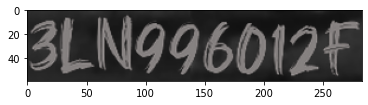

2FV271041L   [(60, 384, 3)]


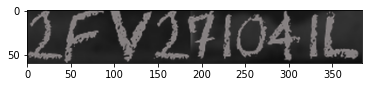

2FV413012A   [(60, 315, 3)]


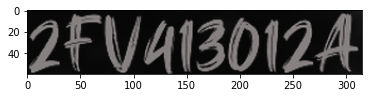

In [87]:
alpha = 0.6
for i,(a,b) in enumerate(generator):
    a = np.array(a)
    print(b,f'  [{a.shape}]')
    black_mat = np.ones(a.shape,dtype=int)*1
    plt.imshow( (a*alpha + black_mat*(1-alpha)).astype('int'))    
    plt.show()
    if i>1:break

# Mix background & target image

In [89]:
sample_size = 20

# background generator
sample_background = generate_back_sample(sample_size)
sample_back_hollow = [generate_hollow(**x) for x in sample_background]

In [90]:
# text generator
sample_tartext=[]
for i,(fake_img, lbl) in enumerate(generator):
    if i>sample_size:break
    sample_tartext.append((fake_img, lbl))

In [91]:
def final_fake(back_img,back_points,back_color,tar_img,rotate_img=0):
    # text image
    fake_array = np.array(tar_img)
    fake_array[fake_array<10] = back_color
    #fake_array[fake_array<250] = 60
    random_kernel = np.random.choice(range(5,20),2)
    fake_array = cv2.blur(fake_array,tuple(random_kernel))
    if rotate_img:
        fake_array = cv2.rotate(fake_array,cv2.ROTATE_180)
    
    # mix background & text
    fix_height, fix_weight = back_points[1]-back_points[0],back_points[-1]-back_points[-2]
    fake_array = cv2.resize(fake_array,(fix_weight,fix_height),interpolation=cv2.INTER_AREA)
    back_img[back_points[0]:back_points[1],back_points[2]:back_points[3],:] = fake_array
    return back_img

def bound2box(x_min,x_max,y_min,y_max):
    return np.array([[[x_min,y_min],[x_max,y_min],[x_max,y_max],[x_min,y_max]]])

In [92]:
import os
cur_path = os.getcwd()

[sample image:  1] 
 {'name': '/workspace/anson_test/work_data/csc_competition/fake_data_generate/dataset/3LP563013A_1.png', 'label': '3LP563013A', 'box': array([[[420, 510],
        [470, 510],
        [470, 856],
        [420, 856]]]), 'angle': '0'}


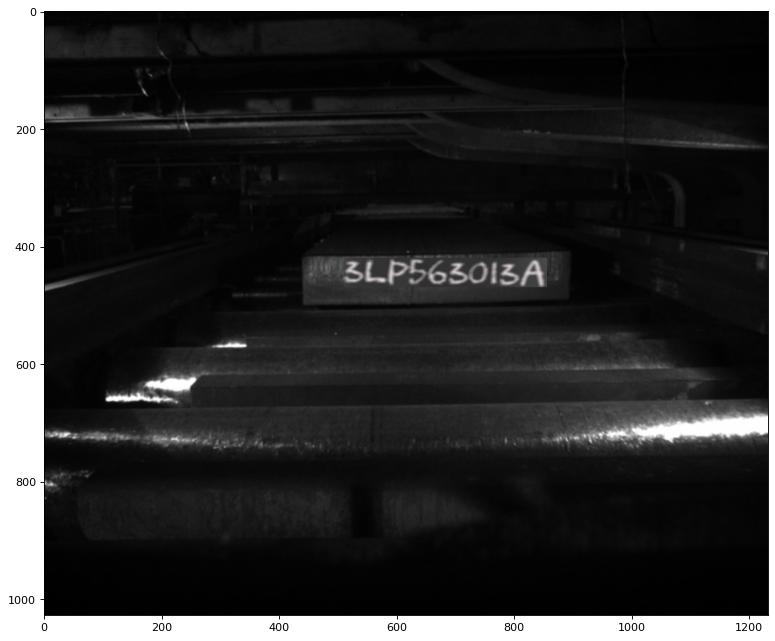

[sample image:  2] 
 {'name': '/workspace/anson_test/work_data/csc_competition/fake_data_generate/dataset/3LR436033F_2.png', 'label': '3LR436033F', 'box': array([[[420, 510],
        [470, 510],
        [470, 856],
        [420, 856]]]), 'angle': '0'}


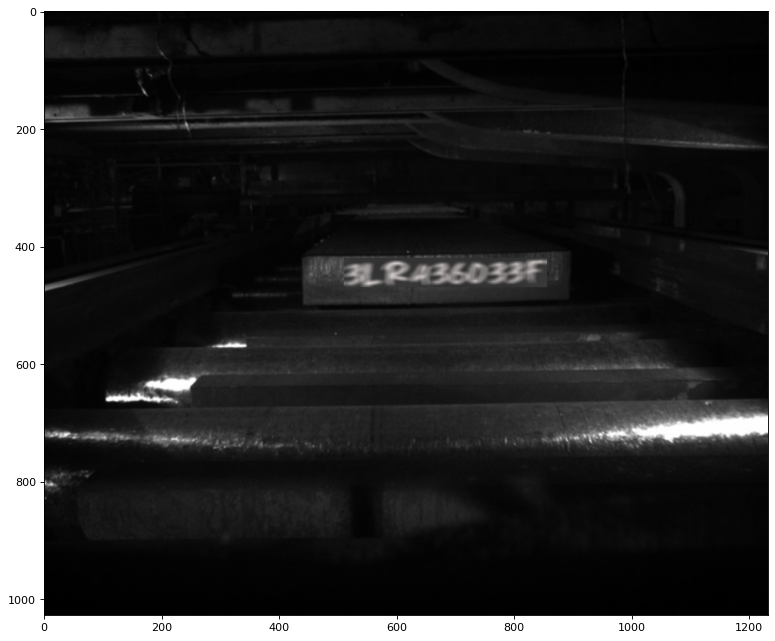

[sample image:  3] 
 {'name': '/workspace/anson_test/work_data/csc_competition/fake_data_generate/dataset/2FW92403_3.png', 'label': '2FW92403', 'box': array([[[420, 510],
        [470, 510],
        [470, 856],
        [420, 856]]]), 'angle': '0'}


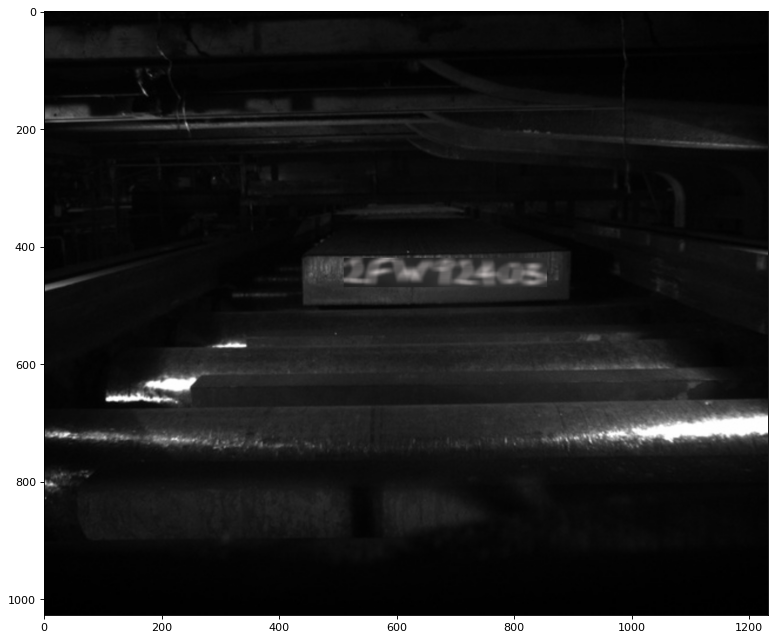

[sample image:  4] 
 {'name': '/workspace/anson_test/work_data/csc_competition/fake_data_generate/dataset/2FW823011A_4.png', 'label': '2FW823011A', 'box': array([[[420, 510],
        [470, 510],
        [470, 856],
        [420, 856]]]), 'angle': '0'}


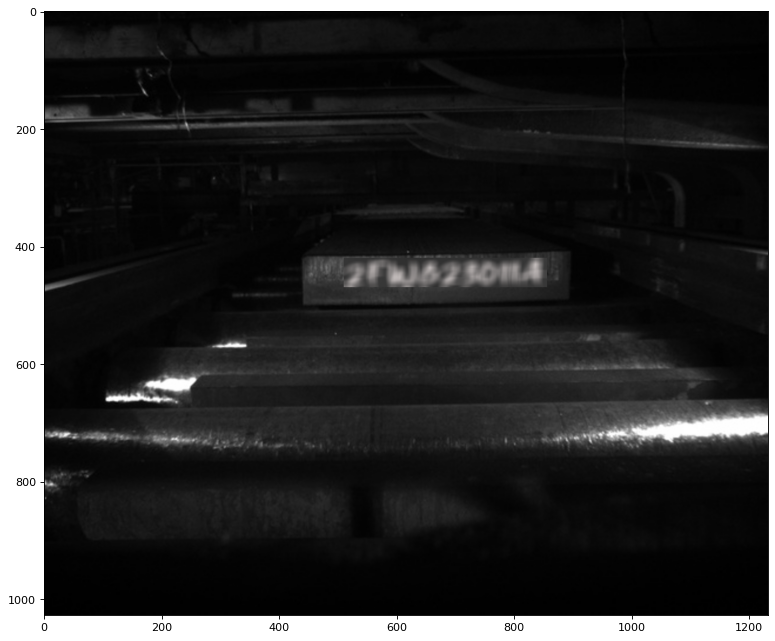

In [93]:
n_sample   = 4    # must smaller than back_size*tar_size
back_size  = 2     # must smaller than sample_size
tar_size   = 4     # must smaller than sample_size
show_image = 1 #False
save_image = 0 #True

n_count = 0
data_record = []
for i in range(back_size):
    if n_count==n_sample:break
    for j in range(tar_size):
        if n_count==n_sample:break
        n_count +=1
        random_rotate = np.random.binomial(1,0.1,size=1)[0]
        tmp_fake = final_fake(sample_back_hollow[i][0],
                              sample_back_hollow[i][1:-1],
                              sample_back_hollow[i][-1],
                              sample_tartext[j][0],
                              random_rotate)
        sample_box = bound2box(*sample_back_hollow[i][1:-1])
        
        # handle label
        _label = sample_tartext[j][1].replace('-','').replace(' ','')
        _filename = cur_path + f'/det_fake_dataset/{_label}_{n_count}.png'
        mark = {'name' : _filename,
                'label': _label,
                'box'  : sample_box,
                'angle': '180' if random_rotate else '0'
               }
        if save_image:
            cv2.imwrite(_filename, tmp_fake)
        data_record.append(mark)
        
        # show 
        if show_image:
            print(f"[sample image:{n_count:3d}] \n {mark}",)
            plt.figure(figsize=(20, 10), dpi=80)
            plt.imshow(tmp_fake)
            plt.show()
        else:
            print(f"[sample image:{n_count:3d}]",end='\r')

fake_df = pd.DataFrame(data_record)[['name','box','angle','label']]
fake_df.to_excel('det_fake_label.xlsx','index=0')